In [1]:
import numpy as np
from scipy.linalg import eig
from scipy.optimize import minimize,rosen_der
import matplotlib.pyplot as plt
from numpy import array
import time

In [19]:
def arrange_in_decreasing_order(arr):
    # Enumerate the array to keep track of original positions
    enumerated_arr = list(enumerate(arr))

    # Sort the array in decreasing order based on the values
    sorted_arr = sorted(enumerated_arr, key=lambda x: x[1], reverse=True)

    # Extract the original positions after sorting
    original_positions = [index for index, _ in sorted_arr]

    # Extract the values in decreasing order
    sorted_values = [value for _, value in sorted_arr]

    return sorted_values, original_positions

# Example usage:
original_array = np.array([2, 5, 8])
sorted_values, original_positions = arrange_in_decreasing_order(original_array)

# print("Original Array:", original_array)
# print("Values in Decreasing Order:", sorted_values)
# print("Original Positions:", original_positions)

In [20]:
# Constants and matrices definitions
GZ_F = 1.1668 * 1e-5 # Fermi constant in GeV^-2 determined in Z decay
mH =  210 # 1000  # Mass of new charged doublet Higgs in GeV
mS =  200  # Mass of new charged singlet Higgs in GeV
me = 0.511 * 10**6  # Electron mass in eV
mmu = 106 * 10**6  # Muon mass in eV
mtau = 1777 * 10**6  # Tau mass in eV
c_beta =   0.9 # np.cos(np.arcsin(-2*(1e-6)*246/(mH^2-mS^2))/2) #    mixing angle between singlet and doublet
theta_emu, theta_eta, theta_muta = [0 for _ in range(3)] # Phase of singlet couplings

# Singlet Yukawa coupling
def YS(Yemu, Yeta, Ymuta, theta_emu, theta_eta, theta_muta):
    return np.array([
        [0, Yemu*np.exp(1j*theta_emu), Yeta*np.exp(1j*theta_eta)],
        [-Yemu*np.exp(1j*theta_emu), 0, Ymuta*np.exp(1j*theta_muta)],
        [-Yeta*np.exp(1j*theta_eta), -Ymuta*np.exp(1j*theta_muta), 0]
    ])
# Doublet Yukawa coupling
def YH(Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu):
    return np.array([
        [Mee, Memu, Meta],
        [Mmue, Mmumu, Mmuta],
        [Mtae, Mtamu, Mtata]
    ])

# Loop coefficient
def k(c_beta, mS,mH):
    return (2 * c_beta * np.sqrt(1 - c_beta**2)) / (16 * np.pi**2) * np.log((mS**2) / (mH**2))
# Lepton diagonal mass matrix
Ml = np.diag([me, mmu, mtau])
# # Neutrino mixing matrix
# def M_nu(Yemu, Yeta, Ymuta, Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu):
#     ys = YS(Yemu, Yeta, Ymuta, theta_emu, theta_eta, theta_muta)
#     yh = YH(Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu)
#     return k(c_beta, mS,mH)*(ys @ Ml @ yh.T + yh @ Ml @ ys.T)
def M_nu(Mee,Mmumu, Mtata, Memu, Meta, Mmuta):
    # Mee = 0.01/k(c_beta, mS,mH)
    return k(c_beta, mS,mH)*np.array([
        [Mee, Memu, Meta],
        [Memu, Mmumu, Mmuta],
        [Meta, Mmuta, Mtata]
        ])
# # Diagonalizing mixing mass matrix function
# def Eigen(Yemu, Yeta, Ymuta,Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu):
#     m_nu = M_nu(Yemu, Yeta, Ymuta, Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu)
#     return eig(m_nu.conj().T @ m_nu)
def Eigen(Mee,Mmumu, Mtata, Memu, Meta, Mmuta):
    m_nu = M_nu(Mee,Mmumu, Mtata, Memu, Meta, Mmuta)
    return eig(m_nu.conj().T @ m_nu)
# Extract squared mass eigen
def EiValue(eigen):
    sorted_values, original_positions = arrange_in_decreasing_order(eigen[0].real)
    return sorted_values
# Extract eigenvector
def EiVectors(eigen):
    sorted_values, original_positions = arrange_in_decreasing_order(eigen[0].real)
    return eigen[1][:,original_positions]

# The NH rearranging matrix
NHTransposematrix = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
# The IH rearranging matrix
IHTransposematrix = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])

# U_PMNS in NH
def NHUPMNS(eigen):
    return np.dot(EiVectors(eigen), NHTransposematrix)
# delta m^2_12 function
def NHDeltaM12(eigen):
    return EiValue(eigen)[1] - EiValue(eigen)[2]
# delta m^2 function
def NHDeltaM(eigen):
    return EiValue(eigen)[0] - 0.5 * (EiValue(eigen)[2] + EiValue(eigen)[1])

# U_PMNS in IH
def IHUPMNS(eigen):
    return np.dot(EiVectors(eigen), IHTransposematrix)
# delta m^2_12 function
def IHDeltaM12(eigen):
    return EiValue(eigen)[0] - EiValue(eigen)[1]
# delta m^2 function
def IHDeltaM(eigen):
    return EiValue(eigen)[2] - 0.5 * (EiValue(eigen)[0] + EiValue(eigen)[1])

# Oscillation functions (in squared unit)
def c12(U11, U13):
    return abs(U11)**2 / (1 - abs(U13)**2)

def s12(U11, U13):
    return 1 - c12(U11, U13)

def c23(U13, U33):
    return abs(U33)**2 / (1 - abs(U13)**2)

def s23(U13, U33):
    return 1 - c23(U13, U33)

def s13(U13):
    return abs(U13)**2

def c13(U13):
    return 1 - s13(U13)

# Note: This translation assumes that `Eigen` function's output will be compatible with subsequent functions. 
# You may need to adjust the output format of `Eigen` to match the expected input format of other functions.

In [21]:
# The global fit function
def Global_fit_function(array,coupling=0):
    # for i in range(len(Couling_value)):
    #     if i == coupling:
    #         Couling_value[i] = array[0]
    M  = Eigen(*array)
    # U_PMNS in NH
    UPMNS = NHUPMNS(M)
    # Exp. value in NH
    # Mass constraints
    deltaM12_ex = 7.37*1e-05 # eV^2
    deltaM12_1dev = (7.97-6.93)*1/3*1e-05
    deltaM_ex = 2.5*1e-03 # eV^2
    deltaM_1dev = (2.63-2.37)*1/3*1e-03
    # Mixing angle constraints in squared unit
    s12_ex = 0.297
    s12_1dev = (0.354-0.25)*1/3
    s13_ex = 0.0214
    s13_1dev = (0.0246-0.0186)*1/3
    s23_ex = 0.437
    s23_1dev = (0.616-0.379)*1/3
    # Xi^2 
    Ftarget = ((NHDeltaM12(M) - deltaM12_ex)/(deltaM12_1dev))**2 + ((NHDeltaM(M) - deltaM_ex)/(deltaM_1dev))**2 + ((s12(UPMNS[0, 0], UPMNS[0, 2]) - s12_ex)/(s12_1dev))**2  + ((s23(UPMNS[0, 2], UPMNS[2, 2]) -s23_ex)/(s23_1dev))**2 + ((s13(UPMNS[0, 2]) -s13_ex)/(s13_1dev))**2 
    return Ftarget

In [22]:
def FiniteDiff_exact(parameters,coupling, epsilon=1e-14, l_rate=1e-29, ite=10000, tol=1e-3 ,pri = 1):
    Deriva = [[] for _ in range(len(parameters))]
    Upd_para = []
    vqe = []
    result = Global_fit_function(parameters,coupling=coupling)
    while 0.5 < Global_fit_function(parameters): # for _ in range(ite):#
        
        Dvqe = [0 for _ in range(len(parameters))]
        fix_parameters = list(parameters)  # Create a copy of parameters
        for i in range(len(parameters)):
            finite_diff = [0 for _ in range(len(parameters))]
            finite_diff[i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(Global_fit_function([fix_parameters[j] + finite_diff[j] for j in range(len(fix_parameters))],coupling) -
                                        Global_fit_function([fix_parameters[j] - finite_diff[j] for j in range(len(fix_parameters))],coupling)))
            # print(Global_fit_function([fix_parameters[j] + finite_diff[j] for j in range(len(fix_parameters))]))
            # print(Global_fit_function([fix_parameters[j] - finite_diff[j] for j in range(len(fix_parameters))]),'\n')
            parameters[i] -= l_rate * Dvqe[i]
            # Upd_para[i].append(parameters[i])
            # Deriva[i].append(Dvqe[i])
        if result < Global_fit_function(parameters,coupling=coupling):
            print('Loop break due to divergence')
            for i in range(len(parameters)):
                parameters[i] += l_rate * Dvqe[i]
            break
        elif result-Global_fit_function(parameters,coupling=coupling)<tol:
            print('Convergence too slow')
            for i in range(len(parameters)):
                parameters[i] += l_rate * Dvqe[i]
            break
        else:
            result = Global_fit_function(parameters,coupling=coupling)

        # print(np.dot(Dvqe,l_rate))
        if pri == 1:
            print(Global_fit_function(parameters,coupling=coupling))

    return result


In [88]:
print(NHDeltaM12(Eigen(*Mass_test)))
print(s23(NHUPMNS(Eigen(*Mass_test))[0,2], NHUPMNS(Eigen(*Mass_test))[2, 2]))
print(s12(NHUPMNS(Eigen(*Mass_test))[0,0], NHUPMNS(Eigen(*Mass_test))[0, 2]))
print(s13(NHUPMNS(Eigen(*Mass_test))[0,2]))

7.364364223046339e-05
0.4518121843091347
0.2980631996194215
0.021352358014385613


Yemu, Yeta, Ymuta, Mee, Mmumu, Mtata, Memu, Meta, Mmuta, Mmue, Mtae, Mtamu

In [185]:
coupling = 1
initial_parameters = np.random.rand(12)*10**-4 # np.concatenate((np.random.rand(3)*10**-7,np.random.rand(9)*10**-2))# 
# random_array = np.random.uniform(low=-1, high=1, size=12)
# initial_parameters = list(np.dot(random_array[0:7],1e-8))+[random_array[7],random_array[8]]

In [7]:
# exclude_parameters = [initial_parameters[0],initial_parameters[1],initial_parameters[2]]
# initial_parameters = list(filter(lambda x: x not in exclude_parameters, initial_parameters))

In [34]:
re = FiniteDiff_exact(parameters=initial_parameters,coupling=coupling, epsilon= 1*1e-8, l_rate=1e-28, tol=1e-4, ite=1000, pri = 1)

Loop break due to divergence


In [51]:
initial_parameters = result.x

In [58]:
result = minimize(Global_fit_function,initial_parameters, method='COBYLA', tol=1e-9, options={'disp': True, 'maxiter': 1000})
print(result.fun)
print(result.x)

51.67097267426297
[-80.5824661  -75.15134174 -88.99634562 103.41055575 -91.94811828]


In [59]:
a = result.fun
initial_parameters = result.x 
while a > 5:   
    
    result = minimize(Global_fit_function,initial_parameters, method='COBYLA', tol=1e-9, options={'disp': True, 'maxiter': 1000})
    initial_parameters = result.x 
    
    if abs(result.fun - a) < 1e-6 or (result.fun - a) > 100:
        # print('Break')
        break
    a = result.fun

In [35]:
Solution = []
i = 1666

In [36]:
Number_data = 2000
xi2_value = 5
while i < Number_data:
    random_array = np.random.uniform(-2, 2, 6)
    initial_parameters = [np.random.choice([-1,1])*np.random.uniform(0,10)*10**random_array[i] for i in range(6)]# np.concatenate((np.random.rand(1)*10**-3,np.random.rand(5)*10**-1)) # np.random.rand(6)*10**0 #       
    result = minimize(Global_fit_function,initial_parameters, method='COBYLA', tol=1e-9, options={'disp': True, 'maxiter': 1000})
    a = result.fun
    initial_parameters = result.x 
    while a > xi2_value:   
        
        result = minimize(Global_fit_function,initial_parameters, method='COBYLA', tol=1e-9, options={'disp': True, 'maxiter': 1000})
        initial_parameters = result.x 
        
        if abs(result.fun - a) < 1e-4 or (result.fun - a) > 100:
            # print('Break')
            break
        a = result.fun
    if a < xi2_value: 
        i+=1
        print(i)
        Solution.append(result.x)

1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866


In [24]:
def LFV_condition(array):
    # mu to 3e
    def muto3e(array):
        return array[3]**2*(array[6]**2+array[9]**2) < 2.9*1e-21*mH**4
    
    # tau to 3e
    def tauto3e(array):
        return array[3]**2*(array[7]**2+array[10]**2) < 4.47*1e-16*mH**4
    
    # tau to 3mu
    def tauto3mu(array):
        return array[4]**2*(array[8]**2+array[11]**2) < 3.48*1e-16*mH**4
    
    # tau to mu2e
    def tautomu2e(array):
        return (array[9]**2*array[7]**2+2*array[6]**2*array[7]**2+array[6]**2*array[10]**2+2*array[9]**2*array[10]**2) < 7.45*1e-16*mH**4
    
    # tau to e2mu
    def tautoe2mu(array):
        return (array[6]**2*array[8]**2+2*array[6]**2*array[11]**2+array[9]**2*array[11]**2+2*array[9]**2*array[8]**2) < 8.45*1e-16*mH**4
    
    # tau to 2mue
    def tauto2mue(array):
        return ((2*array[8]*array[9]-array[7]*array[4])**2+(2*array[11]*array[6]-array[10]*array[4])**2+4*array[6]**2*array[8]**2+4*array[11]**2*array[9]**2+7*array[7]**2*array[4]**2+7*array[10]**2*array[4]**2) < 2.69*1e-15*mH**4
    
    # tau to 2emu
    def tauto2emu(array):
        return ((2*array[7]*array[6]-array[8]*array[3])**2+(2*array[10]*array[9]-array[11]*array[3])**2+4*array[7]**2*array[9]**2+4*array[6]**2*array[10]**2+7*array[8]**2*array[3]**2+7*array[11]**2*array[3]**2) < 1.79*1e-15*mH**4
    
    return muto3e(array) and tauto3e(array) and tauto3mu(array) and tautomu2e(array) and tautoe2mu(array) and tauto2mue(array) and tauto2emu(array)

In [25]:
def Michel_condition(array):
    msinglet2 = (c_beta**2/(mS**2)+(1-c_beta**2)/(mH**2))**-1
    mdoublet2 = (c_beta**2/(mH**2)+(1-c_beta**2)/(mS**2))**-1
    Doublet_sum = 1/(16*mdoublet2**2)*sum(array[i]**2 * array[j]**2 for i in [4, 6, 11] for j in [3, 9, 10])
    a_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[2]*array[3]-array[0]*array[10])**2+(array[2]*array[9])**2+(array[0]*array[9])**2) # a_(L=-2)
    a_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[0]*array[11]+array[1]*array[4])**2+(array[1]*array[6])**2+(array[0]*array[6])**2)#  a_(L=2)
    c_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[2]*array[3]+array[0]*array[10])**2+(array[2]*array[9])**2+(array[0]*array[9])**2+4*(array[0]*array[3])**2+4*(array[2]*array[10])**2) # c_(L=-2)
    c_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/16*((-array[0]*array[11]-array[1]*array[4])**2+(array[1]*array[6])**2+(array[0]*array[6])**2+4*(array[0]*array[4])**2+4*(array[1]*array[11])**2) # c_(L=-2)
    a = a_1+a_2
    a_prime = a_1 - a_2
    b = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)+Doublet_sum
    b_prime = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)-Doublet_sum
    c = c_1 + c_2
    c_prime = c_2 - c_1  

    def de_rho(array):
        return -47 * 1e-5 < 3*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                        +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) < 5 * 1e-5

    def de_delta(array):
        return  1.3 * 1e-4 < 21*(1/(mS**2)-1/(mH**2))**2/(-3*a_prime+4*b_prime-14*c_prime)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                                                 -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                                 +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]]))  < 8.1 * 1e-4
    
    def de_xi(array):
        return 2 * 1e-4 < (8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*sum(array[i]**2 * array[j]**2 for i,j in [[0,4],[0,4],[0,6],[0,11],[1,11],[1,11],[1,6],[1,4]])
                            + 8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)**2/16*(3/2*sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[11,1,11,1]])
                                                                                                    -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                    +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2]])) 
                            +2*Doublet_sum/(a+4*b+6*c))  < 25 * 1e-4
    return  de_rho(array) and de_delta(array)  and de_xi(array)


Yemu 0, Yeta 1, Ymuta 2, Mee 3, Mmumu 4, Mtata 5, Memu 6, Meta 7, Mmuta 8, Mmue 9, Mtae 10, Mtamu 11

In [26]:
def filter_and_sort(arrays, condition):
    """
    Filters and sorts a list of 12-element arrays based on a given condition.

    Parameters:
        arrays (list): List of 12-element arrays to be filtered and sorted.
        condition (function): A function defining the condition for filtering.

    Returns:
        list: Filtered and sorted list of arrays.
    """
    satisfying_arrays = [array for array in arrays if condition(array)]
    return  satisfying_arrays # sorted(satisfying_arrays, key=lambda x: sum(x))  # Sorting by sum of elements

In [32]:
filtered_sorted_arrays_LFV = filter_and_sort(Solution, LFV_condition)
print("Filtered and sorted arrays:", len(filtered_sorted_arrays_LFV))

Filtered and sorted arrays: 0


In [31]:
filtered_sorted_arrays_Michel = filter_and_sort(Solution, Michel_condition)
print("Filtered and sorted arrays:", len(filtered_sorted_arrays_Michel))

Filtered and sorted arrays: 0


In [40]:
def save_arrays_to_text_file(arrays, filename):
    """
    Saves a list of arrays to a text file.

    Parameters:
        arrays (list): List of arrays to be saved.
        filename (str): Name of the file to save.
    """
    with open(filename, 'w') as file:
        for array in arrays:
            np.savetxt(file, array)
            file.write('\n')  # Separate arrays by a newline

# Example usage
filename = 'Coupling Data gen_matrix c_beta 0.9 mHS 210 200 GeV plus.txt'
save_arrays_to_text_file(Solution, filename)


In [32]:
def read_arrays_from_text_file(filename):
    """
    Reads arrays from a text file where each array has 12 elements.

    Parameters:
        filename (str): Name of the file to read.

    Returns:
        list: List of arrays read from the file.
    """
    arrays = []
    with open(filename, 'r') as file:
        array_data = []
        for line in file:
            array_data.extend(map(float, line.strip().split()))
            if len(array_data) == 6:
                arrays.append(np.array(array_data))
                array_data = []
    return arrays

# Example usage
filename = 'Coupling Data gen_matrix c_beta 0.9 mHS 210 200 GeV plus.txt'
Solution = read_arrays_from_text_file(filename)
# # Transform tuple to list of arrays
# Solution = np.array([np_array.tolist() for np_array in Solution])

In [269]:
# Extract the first two elements for each array
first_two_elements = Solution[:, :2]
# Refine the plot data into specific range
Data = list(first_two_elements)
m = 0
for i in range(len(first_two_elements)):
    if abs(first_two_elements[i][0])> 1e-8 or  abs(first_two_elements[i][1])> 1e-8:
        Data = np.delete(Data, i-m, axis=0)
        m+=1

In [51]:
Data = np.concatenate((Data,Solution))

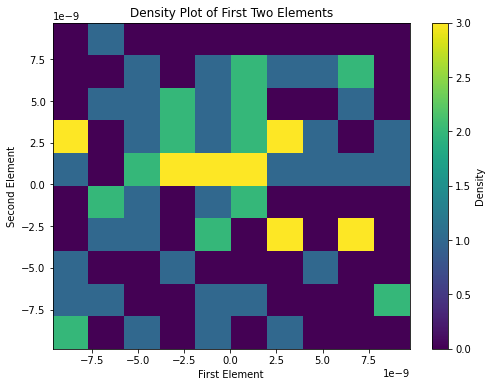

In [270]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data[:, 0], Data[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Density')
plt.xlabel('First Element')
plt.ylabel('Second Element')
plt.title('Density Plot of First Two Elements')
plt.show()